### Structure

Implements a model for large-scale CN NLP training.

In the Main Model section the models architecture is built. Whenever changes in the architecture are made the Experiments are used to validate them.

In [1]:
import tensorflow as tf

tf_version = tf.__version__
print("Tensorflow: ", tf_version)

tf_version_split = tf_version.split('.')
assert int(tf_version_split[0])==2 and int(tf_version_split[-2])>=4, f"Tensorflow version should be '2.4+,x', given {tf_version}"

Tensorflow:  2.4.0


### Main Model

#### WIP - DATA PREPARATION

#### WIP - Model Structure

In [ ]:
# TODO: Remove dependency on performer repo?
!git clone https://github.com/xl402/performer.git

import os
import sys
module_path = os.path.abspath(os.path.join('./performer'))
if module_path not in sys.path:
    sys.path.append(module_path)

from performer.networks.linear_attention import Performer   

Cloning into 'performer'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 691 (delta 64), reused 148 (delta 37), pack-reused 509
Receiving objects: 100% (691/691), 691.80 KiB | 453.00 KiB/s, done.
Resolving deltas: 100% (340/340), done.


In [ ]:
""" Default Model Config """

conf = {
        "vocab_size": 32128,
        "num_layers": 6,
        "attention": 
        .... 
        d_model=512,
        d_kv=64,
        d_ff=2048,
        num_layers=6,
        num_decoder_layers=None,
        num_heads=8,
        relative_attention_num_buckets=32,
        dropout_rate=0.1,
        layer_norm_epsilon=1e-6,
        initializer_factor=1.0,
        feed_forward_proj="relu",
        is_encoder_decoder=True,
        use_cache=True,
        pad_token_id=0,
        eos_token_id=1,
        **kwargs
}

In [ ]:
""" Helper Functions for Model Architecture """

def gelu_new(x):
    """
    Gaussian Error Linear Unit. This is a smoother version of the GELU. Original paper: https://arxiv.org/abs/1606.0841
    Args:
        x: float Tensor to perform activation
    Returns:
        `x` with the GELU activation applied.
    """
    x = tf.convert_to_tensor(x)
    pi = tf.cast(math.pi, x.dtype)
    coeff = tf.cast(0.044715, x.dtype)
    cdf = 0.5 * (1.0 + tf.tanh(tf.sqrt(2.0 / pi) * (x + coeff * tf.pow(x, 3))))

    return x * cdf
    

In [ ]:
""" Wecredo Model Architecture for Large-Scale CN NLP Training """

####################################################
# TF 2.0 Model  constructed using Keras imperative API by sub-classing
# - tf.keras.layers.Layer for the layers
# - tf.keras.Model for the final model
####################################################

class T5LayerNorm(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6, **kwargs):
        """
        Construct a layernorm module in the T5 style No bias and no subtraction of mean.
        """
        super().__init__(**kwargs)
        self.variance_epsilon = epsilon

    def build(self, input_shape):
        """Build shared word embedding layer """
        self.weight = self.add_weight("weight", shape=(input_shape[-1],), initializer="ones")
        super().build(input_shape)

    def call(self, hidden_states):
        variance = tf.math.reduce_mean(tf.math.square(hidden_states), axis=-1, keepdims=True)
        hidden_states = hidden_states * tf.math.rsqrt(variance + self.variance_epsilon)
        return self.weight * hidden_states

# TODO - Define default config? // Remove config calls?
class T5DenseReluDense(tf.keras.layers.Layer):
    def __init__(self, config, **kwargs):
        """
        Constructs a Relu Feed-Forward Layer. This is the default FF in T5. 
        """
        super().__init__(**kwargs)
        self.wi = tf.keras.layers.Dense(config.d_ff, use_bias=False, name="wi")
        self.wo = tf.keras.layers.Dense(config.d_model, use_bias=False, name="wo")
        self.dropout = tf.keras.layers.Dropout(config.dropout_rate)
        self.act = tf.keras.activations.relu

    def call(self, hidden_states, training=False):
        hidden_states = self.wi(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.dropout(hidden_states, training=training)
        hidden_states = self.wo(hidden_states)
        return hidden_states

        













In [ ]:
import mesh_tensorflow as mtf
import tensorflow.compat.v1 as tf
import math
import mesh_tensorflow.transformer as mtf_transformer
import random
from models.utils import parse_inputs, entmax_cross_entropy_with_logits

# --------------------------------------------------------------------------------
# LAYERS:

sentinel = object()


def exists(x):
    return x is not None


def identity(x, *args, **kwargs):
    return x


def is_incremental_inference(context):
    return exists(context) and context.mode == "incremental"


def norm(x, axis, epsilon=1e-8):
    x -= mtf.reduce_mean(x, reduced_dim=axis, name="norm_reduce_mean_u")
    s = mtf.reduce_mean(mtf.square(x), reduced_dim=axis, name="norm_reduce_mean_s")
    return x * mtf.rsqrt(s + epsilon)


# ReZero implementation
def rezero(x, scope, dtype):
    with tf.variable_scope(scope):
        g = mtf.get_variable(x.mesh, "g", [], initializer=tf.constant_initializer(0), dtype=dtype)
        return x * g


def scale_norm(x, scope, *, variable_dtype, axis=sentinel, epsilon=1e-5, params=None):
    if axis is sentinel:
        axis = x.shape[-1]

    with tf.variable_scope(scope):
        g = mtf.get_variable(x.mesh, "g", [], initializer=tf.constant_initializer(1),
                             master_dtype=variable_dtype.master_dtype,
                             slice_dtype=variable_dtype.slice_dtype,
                             activation_dtype=variable_dtype.activation_dtype)

        x = norm(x, axis, epsilon)
        x = x * g
        return x


def layer_norm(x, scope, *, variable_dtype, axis=sentinel, epsilon=1e-5, params=None):
    """Normalize to mean = 0, std = 1, then do a diagonal affine transform."""
    if axis is sentinel:
        axis = x.shape[-1]

    with tf.variable_scope(scope):
        n_state = x.shape[-1]

        g = mtf.get_variable(x.mesh, "g", [n_state], initializer=tf.constant_initializer(1),
                             master_dtype=variable_dtype.master_dtype,
                             slice_dtype=variable_dtype.slice_dtype,
                             activation_dtype=variable_dtype.activation_dtype)
        b = mtf.get_variable(x.mesh, "b", [n_state], initializer=tf.constant_initializer(0),
                             master_dtype=variable_dtype.master_dtype,
                             slice_dtype=variable_dtype.slice_dtype,
                             activation_dtype=variable_dtype.activation_dtype)

        x = norm(x, axis, epsilon)
        x = x * g + b
        return x


### INTEGRATE PERFORMER ATTENTION ###
def linear_attention(q, k, v):
    batch_dim, seq_dim, head_dim, dim_out = (v.shape[0], v.shape[1], v.shape[2], v.shape[3])
    q = mtf.rename_dimension(q, "features_per_head", "features_per_head_in")
    k = mtf.rename_dimension(k, "features_per_head", "features_per_head_in")

    dim_in = k.shape[-1]

    q = mtf.softmax(q, dim_in)
    k = mtf.softmax(k, seq_dim)

    context = mtf.einsum([k, v], output_shape=[batch_dim, head_dim, dim_in, dim_out])
    attn = mtf.einsum([q, context], output_shape=[batch_dim, seq_dim, head_dim, dim_out])
    return attn


def causal_linear_attention(q, k, v, epsilon=1e-6):
    batch_dim, seq_dim, head_dim, dim_out = (v.shape[0], v.shape[1], v.shape[2], v.shape[3])
    q = mtf.rename_dimension(q, "features_per_head", "features_per_head_in")
    k = mtf.rename_dimension(k, "features_per_head", "features_per_head_in")

    dim_in = k.shape[-1]

    q = mtf.softmax(q, dim_in)
    k = mtf.exp(k)

    cumulative_k = mtf.cumsum(k, seq_dim)
    context = mtf.einsum([k, v], output_shape=[batch_dim, seq_dim, head_dim, dim_in, dim_out])
    cumulative_context = mtf.cumsum(context, seq_dim)

    cumulative_context /= (cumulative_k + epsilon)
    attn = mtf.einsum([q, cumulative_context], output_shape=[batch_dim, seq_dim, head_dim, dim_out])
    return attn


def linear(x, scope, nf, *, w_init_stdev=0.02, variable_dtype, params=None, scale=False):
    # nf = number of features
    if params["scale_by_depth"] and scale:
        # Scale by sqrt(num_layers), only happens at the final projection before a res block output
        w_init_stdev = w_init_stdev * (1. / math.sqrt(params["n_layer"]))
    if params["scale_by_in"]:  # Scale by sqrt(num_input_features)
        w_init_stdev = w_init_stdev * (1. / math.sqrt(x.shape[-1].size))  # Dimension is a namedtuple of (name, size)
    # Not in the variable_scope because mtf already has a variable_scope in it
    with tf.variable_scope("conv1d_main"):
        c = mtf.layers.dense(x, new_dims=[nf], reduced_dims=[x.shape[-1]], name=scope, use_bias=True,
                             kernel_initializer=tf.random_normal_initializer(stddev=w_init_stdev),
                             variable_dtype=variable_dtype,
                             )
        return c


def memory_key_values(k, v, num_mem_kv, dim_batch, dim_heads, variable_dtype, mesh):
    """memory / key values from all attention paper"""

    dim_mem_kv = mtf.Dimension("mem_kv_sequence", num_mem_kv)
    emb_dim = k.shape[-1]
    mem_std = 1 / math.sqrt(emb_dim.size)

    mem_k = mtf.get_variable(mesh, "mem_k", mtf.Shape([dim_mem_kv, dim_heads, emb_dim]),
                             initializer=tf.random_normal_initializer(stddev=mem_std),
                             master_dtype=variable_dtype.master_dtype,
                             slice_dtype=variable_dtype.slice_dtype,
                             activation_dtype=variable_dtype.activation_dtype,
                             )
    mem_v = mtf.get_variable(mesh, "mem_v", mtf.Shape([dim_mem_kv, dim_heads, emb_dim]),
                             initializer=tf.random_normal_initializer(stddev=mem_std),
                             master_dtype=variable_dtype.master_dtype,
                             slice_dtype=variable_dtype.slice_dtype,
                             activation_dtype=variable_dtype.activation_dtype)

    mem_k, mem_v = map(lambda t: mtf.broadcast(t, [dim_batch, dim_mem_kv, dim_heads, emb_dim]),
                       (mem_k, mem_v))
    mem_k, mem_v = map(lambda t: mtf.rename_dimension(t, "mem_kv_sequence", "sequence"),
                       (mem_k, mem_v))

    k = mtf.concat([mem_k, k], "sequence")
    v = mtf.concat([mem_v, v], "sequence")
    return k, v


def attn(x, scope, n_state, *, attention_type, params, bias, dim_seq, memory_length_dim, variable_dtype, context=None):
    # x :: [batch, seq, n_embd]
    x_shape, dim_batch, *_, dim_embd, mesh = x.shape, *x.shape, x.mesh

    # n_state is the same as config["n_embd"], which is also the same as dim_embd.
    assert n_state.size % params["n_head"] == 0

    dim_heads = mtf.Dimension("heads", params["n_head"])

    num_mem_kv = params.get("num_mem_kv", 0)
    use_num_mem_kv = num_mem_kv > 0

    with tf.variable_scope(scope):
        # Compute attention inputs
        dim_kv = mtf.Dimension("features_per_head", params["n_embd"] // params["n_head"])
        mtfparams = mtf.transformer.attention.attention_params_simple(
            x.mesh,
            io_dim=dim_embd,
            kv_dim=dim_kv,
            heads_dim=dim_heads,
            variable_dtype=variable_dtype
        )
        q = mtfparams.compute_q(x)
        k = mtfparams.compute_k(x)
        v = mtfparams.compute_v(x)

        if is_incremental_inference(context):
            one_hot = mtf.one_hot(context.position - 1, dim_seq, dtype=variable_dtype.master_dtype)
            inv_one_hot = 1.0 - one_hot
            old_k, old_v = context.get_states(2)
            k = old_k * inv_one_hot + k * one_hot
            v = old_v * inv_one_hot + v * one_hot

        if exists(context):
            context.record_new_states([k, v])

        with tf.variable_scope("attention"):
            if attention_type == "local":
                # `local_attention_1d` has built in autoregressive masking, so we don't need mask_attn_weights.
                radius = params.get("local_attention_radius", 256)

                if is_incremental_inference(context):
                    q *= one_hot

                a = mtf_transformer.attention.local_attention_1d(
                    q, k, v,
                    length_dim=k.shape[1],
                    key_dim=dim_kv,
                    value_dim=dim_kv,
                    radius=radius,
                    length_dim_num_splits=1,
                    fully_autoregressive=params["causal"],
                    attention_kwargs={},
                )

                if is_incremental_inference(context):
                    a = mtf.gather(a, context.position - 1, dim_seq)

            elif attention_type == "global":

                # TODO: pass in fake context
                # Broadcast mask bias across batch and heads
                if exists(bias):
                    if not is_incremental_inference(context):
                        broadcasted_bias = mtf.broadcast(bias, [dim_batch, dim_heads, bias.shape[-2], bias.shape[-1]])
                    else:
                        # In the incremental case, a custom mask needs to be built that masks out all key/values that are greater than the current position
                        bias = mtf.gather(bias, context.position - 1, dim_seq)
                        broadcasted_bias = mtf.broadcast(bias, [dim_batch, dim_heads, bias.shape[-1]])

                # memory key / values, from all-attention paper
                if use_num_mem_kv:
                    k, v = memory_key_values(k, v, num_mem_kv, dim_batch, dim_heads, variable_dtype, mesh)

                k = mtf.replace_dimensions(k, k.shape[1], memory_length_dim)
                v = mtf.replace_dimensions(v, v.shape[1], memory_length_dim)

                attn_dropout_rate = params["attn_dropout"] if params["mode"] == "train" else 0

                a = mtf_transformer.attention.attention(
                    q, k, v,
                    memory_length_dim=memory_length_dim,
                    key_dim=dim_kv,
                    value_dim=dim_kv,
                    bias=broadcasted_bias,
                    dropout_rate=attn_dropout_rate
                )

            elif attention_type == "linear":
                linear_attn_fn = causal_linear_attention if params["causal"] else linear_attention
                a = linear_attn_fn(q, k, v)

            else:
                raise NotImplementedError("Unknown attention type {}!".format(attention_type))

        with tf.variable_scope("compute_output"):
            a = mtfparams.compute_output(a, x_shape)

        with tf.variable_scope("compute_output_bias"):
            b = mtf.get_variable(x.mesh, "o_b", [dim_embd], initializer=tf.constant_initializer(0),
                                 master_dtype=variable_dtype.master_dtype,
                                 slice_dtype=variable_dtype.slice_dtype,
                                 activation_dtype=variable_dtype.activation_dtype)
            a += b

        if params["mode"] == "train" and params["res_dropout"] > 0:
            a = mtf.dropout(a, rate=params["res_dropout"], name="res_dropout")
        return a


def get_activation_fn(params):
    activation_fn = params.get("activation_fn", "gelu")
    

    def _arcsinh(x):
        return mtf.log(x + mtf.sqrt(1 + x ** 2))
    def _var(x, init):
        return mtf.get_variable(x.mesh, f"activation-{random.randint(0, 2**32):x}", [], initializer=tf.constant_initializer(init), dtype=x.dtype)
    def _pos_var(x, val):
        return mtf.softplus(_var(x, 0)) + val
    
    if activation_fn == "gelu": # https://arxiv.org/abs/1606.08415
        return mtf.gelu
    elif activation_fn == "relu":
        return mtf.relu
    elif activation_fn == "sigmoid":
        return mtf.sigmoid
    elif activation_fn == "tanh":
        return mtf.tanh
    elif activation_fn == "selu": # https://arxiv.org/abs/1706.02515
        return mtf.selu
    elif activation_fn == "elu": # https://arxiv.org/abs/1511.07289
        return mtf.elu
    elif activation_fn == "lrelu001":
        return lambda x: mtf.leaky_relu(x, alpha=0.01)
    elif activation_fn == "lrelu020":
        return lambda x: mtf.leaky_relu(x, alpha=0.20)

    elif activation_fn == "abs": 
        return mtf.abs
    elif activation_fn == "id":
        return lambda x: x
    elif activation_fn == "sin":
        return mtf.sin
    elif activation_fn == "cos":
        return mtf.cos
    elif activation_fn == "sign":
        return mtf.sign
    elif activation_fn == "triangle_relax":
        return lambda x: mtf.sin(x)-mtf.sin(3*x)/9+mtf.sin(5*x)/25-mtf.sin(7*x)/49
    elif activation_fn == "square_relax":
        return lambda x: mtf.cos(x)-mtf.cos(3*x)/3+mtf.cos(5*x)/5-mtf.cos(7*x)/7
    elif activation_fn == "spike":
        return lambda x: 1/(1+x**2)
    elif activation_fn == "spike2":
        return lambda x: mtf.exp(-x**2)
    
    elif activation_fn == "tanhshrink":
        return lambda x: x - tanh(x)
    elif activation_fn == "softsign":
        return lambda x: x / (mtf.abs(x) + 1)
    elif activation_fn == "softmax":
        return lambda x: mtf.softmax(x, x.shape[-1])
    elif activation_fn == "logsoftmax":
        return lambda x: mtf.log_softmax(x, x.shape[-1])
    elif activation_fn == "bipolarsigmoid":
        return lambda x: mtf.sigmoid(x) * 2 - 1
    elif activation_fn == "rrelu":  # https://arxiv.org/abs/1505.00853
        def _rrelu_fn(x):
            negative_scale = random.random()
            return (negative_scale * mtf.abs(x) + x) / (1 + negative_scale)
        return _rrelu_fn
    elif activation_fn == "elish":  # https://arxiv.org/abs/1808.00783v1
        def _elish_fn(x):
            cond = mtf.cast(mtf.greater(x, 0), x.dtype)
            exp = mtf.exp(x)
            return cond * x / (1 + exp) + (1 - cond) * (exp - 1) / (1 / exp + 1)
        return _elish_fn
    
    elif activation_fn == "silu": # https://arxiv.org/abs/1710.05941
        return mtf.swish
    
    elif activation_fn == "arcsinh":
        return _arcsinh
    
    
    # parametric
    elif activation_fn == "aria":  # https://arxiv.org/abs/1805.08878
        return lambda x: x * (_var(x, 0) + _var(x, 1) / (_pos_var(x, 0) + _var(x, 1) * mtf.exp(_var(x, -1) * x) ** (1 / _pos_var(x, 1))))
    elif activation_fn == "prelu":  # https://arxiv.org/abs/1502.01852
        return lambda x: mtf.leaky_relu(x, alpha=_var(x, 0.2))
    elif activation_fn == "parcsinh":
        return lambda x: _var(x, 1) * _arcsinh(x * _pos_var(x, 1))
    elif activation_fn == "psoftplus":
        return lambda x: _var(x, 1) * mtf.softplus(x * _var(x, 1)) + _var(x, 0)
    elif activation_fn == "proottanh":
        return lambda x: (x ** _pos_var(x, 2) + _pos_var(x, 1)) ** (1 / _pos_var(x, 3)) * mtf.tanh(x)
     
    # https://arxiv.org/abs/1710.05941, https://arxiv.org/abs/1901.02671
    elif activation_fn == "maxsig": 
        return lambda x: mtf.maximum(x, mtf.sigmoid(x))
    elif activation_fn == "cosid": 
        return lambda x: mtf.cos(x) - x
    elif activation_fn == "minsin": 
        return lambda x: mtf.minimum(x, mtf.sin(x))
    elif activation_fn == "maxtanh": 
        return lambda x: mtf.maximum(x, mtf.tanh(x))
    
    elif activation_fn == "softplus":
        return mtf.softplus
    elif activation_fn == "mish": # https://arxiv.org/abs/1908.08681
        return lambda x: x * mtf.tanh(mtf.softplus(x))
    elif activation_fn == "tanhexp": # https://arxiv.org/abs/2003.09855
        return lambda x: x * mtf.tanh(mtf.exp(x))
    elif activation_fn == "lisht": # https://arxiv.org/abs/1901.05894
        return lambda x: x * mtf.tanh(x)
    elif activation_fn == "seagull": # https://arxiv.org/abs/2011.11713
        return lambda x: mtf.log(1 + x ** 2)
    elif activation_fn == "snake": # https://arxiv.org/abs/2006.08195
        return lambda x: x + mtf.sin(x) ** 2
    
    elif activation_fn == "roottanh":  # made up
        return lambda x: (x ** 2 + 1) ** (1/3) * mtf.tanh(x)
    elif activation_fn == "softplusmone":  # made up
        return lambda x: mtf.softplus(x) - 1
    
    else:
        raise ValueError('unknown activation function "activation_fn" in config')

def mlp(x, scope, n_state, *, variable_dtype, params):
    activation_fn = get_activation_fn(params)
    with tf.variable_scope(scope):
        nx = x.shape[-1]
        h = activation_fn(linear(x, "c_fc", n_state, variable_dtype=variable_dtype, params=params))
        h2 = linear(h, "c_proj", nx, variable_dtype=variable_dtype, params=params, scale=True)
        if params["mode"] == "train" and params["res_dropout"] > 0:
            h2 = mtf.dropout(h2, rate=params["res_dropout"], name="mlp_dropout")
        return h2


def mlp_glu(x, scope, n_state, *, variable_dtype, params):
    activation_fn = get_activation_fn(params)
    with tf.variable_scope(scope):
        nx = x.shape[-1]
        h = linear(x, "c_fc", n_state, params=params)

        h, gate = mtf.split(h, h.shape[-1], 2)
        h *= activation_fn(gate)

        h2 = linear(h, "c_proj", nx, variable_dtype=variable_dtype, params=params, scale=True)
        if params["mode"] == "train" and params["res_dropout"] > 0:
            h2 = mtf.dropout(h2, rate=params["res_dropout"], name="mlp_dropout")
        return h2


def block(params, scope, layer_num, bias, sequence_dim, memory_length_dim, variable_dtype, context=None):
    use_mlp_glu = params["mlp_glu"] == True
    use_scale_norm = params["scalenorm"] == True
    use_moe = exists(params["moe_layers"]) and (layer_num in params["moe_layers"])
    use_rezero = params["rezero"] == True
    macaron_attention = params["macaron"] == True

    def fn(x):
        with tf.variable_scope(scope):
            nx = x.shape[-1]  # Grab last dimension from input

            if use_rezero:
                prenorm = identity
            elif use_scale_norm:
                prenorm = scale_norm
            else:
                prenorm = layer_norm

            pre_residual_fn = rezero if use_rezero else identity

            attention_type = params["attention_types"][layer_num]
            
            if macaron_attention:
                mult = 0.5
                mlp_fn = mlp_glu if use_mlp_glu else mlp
                intermediate_size = nx.size * 4 * (1 if not use_mlp_glu else 2)
                # Define intermediate layer of mlp - to split
                dim_intermediate_expanded = mtf.Dimension("intermediate_expanded", intermediate_size)
                m = mlp_fn(x, "mlp_macaron", dim_intermediate_expanded, variable_dtype=variable_dtype, params=params)
                
                x = x + (m * mult)
            else:
                mult = 1

            if attention_type != "none":
                res_x = prenorm(x, "norm_1", variable_dtype=variable_dtype, params=params)
                a = attn(res_x, "attn", nx, attention_type=attention_type,
                         params=params, bias=bias, dim_seq=sequence_dim, memory_length_dim=memory_length_dim,
                         variable_dtype=variable_dtype, context=context)
            else:
                a = x

            x = x + pre_residual_fn(a, "norm_rezero_1", dtype=variable_dtype)

            res_x = prenorm(x, "norm_2", variable_dtype=variable_dtype, params=params)

            if use_moe:
                moe_params = mtf.transformer.moe.HParams()
                mtf.transformer.moe.set_default_moe_hparams(moe_params)
                moe_params.add_hparam("moe_min_expert_capacity", 1)
                moe_params.add_hparam("moe_use_experts_attention", False)

                # Override defaults
                for k, v in params["moe_params"].items():
                    moe_params.add_hparam(k, v)

                moe_train = params["mode"] == "train"

                m, aux_loss = mtf.transformer.moe.transformer_moe_layer_v1(res_x, x.shape[-1], moe_params,
                                                                           train=moe_train,
                                                                           mesh_shape=params["mesh_shape"],
                                                                           layout=params["layout"],
                                                                           activation=params.get("moe_activation", "relu"),
                                                                           variable_dtype=variable_dtype,
                                                                           num_microbatches=params["num_microbatches"])
                m = mtf.dropout(m, rate=params["res_dropout"], name="moe_dropout")
            else:

                mlp_fn = mlp_glu if use_mlp_glu else mlp
                intermediate_size = nx.size * 4 * (1 if not use_mlp_glu else 2)

                # Define intermediate layer of mlp - to split
                dim_intermediate_expanded = mtf.Dimension("intermediate_expanded", intermediate_size)

                m = mlp_fn(res_x, "mlp", dim_intermediate_expanded, variable_dtype=variable_dtype, params=params)
                aux_loss = mtf.zeros(x.mesh, mtf.Shape([]), dtype=variable_dtype.slice_dtype)

            x = x + pre_residual_fn((m*mult), "norm_rezero_2", variable_dtype)
            return x, aux_loss

    return fn


def axial_positional_emb(embd_dim, mesh, params, variable_dtype):
    # Use axial position encoding
    axial_dim_1, axial_dim_2 = params["axial_pos_emb"]

    axial_dim = mtf.Dimension("axial_dim", axial_dim_1 * axial_dim_2)
    dim_axials = [mtf.Dimension(f"axial_dim_{i}", t) for i, t in enumerate((axial_dim_1, axial_dim_2))]

    axial_wpe_1 = mtf.get_variable(mesh, "axial_wpe_1", mtf.Shape([dim_axials[0], embd_dim]),
                                   initializer=tf.random_normal_initializer(stddev=0.01),
                                   master_dtype=variable_dtype.master_dtype,
                                   slice_dtype=variable_dtype.slice_dtype,
                                   activation_dtype=variable_dtype.activation_dtype)

    axial_wpe_2 = mtf.get_variable(mesh, "axial_wpe_2", mtf.Shape([dim_axials[1], embd_dim]),
                                   initializer=tf.random_normal_initializer(stddev=0.01),
                                   master_dtype=variable_dtype.master_dtype,
                                   slice_dtype=variable_dtype.slice_dtype,
                                   activation_dtype=variable_dtype.activation_dtype)

    axial_wpe_1, axial_wpe_2 = map(lambda t: mtf.broadcast(t, [dim_axials[0], dim_axials[1], embd_dim]),
                                   (axial_wpe_1, axial_wpe_2))
    wpe = (axial_wpe_1 + axial_wpe_2) / 2

    wpe = mtf.reshape(wpe, [axial_dim, embd_dim])

    return wpe

# --------------------------------------------------------------------------------
# MODEL:

def model(mtf_features, other_features, params, mesh, variable_dtype, context=None):
    """Wecredo_Model implemented in mesh tensorflow."""

    x, batch_dim, sequence_dim, embd_dim, vocab_dim, embed_sequence_dim = parse_inputs(mtf_features, other_features)

    if is_incremental_inference(context):
        # reshape inputs if in inference mode
        x = mtf.gather(x, context.position - 1, sequence_dim)
        x = mtf.reshape(x, [batch_dim])

    use_axial_pos_emb = params["axial_pos_emb"] is not None

    if not use_axial_pos_emb:
        # Use standard position encoding
        wpe = mtf.get_variable(mesh, "wpe", mtf.Shape([embed_sequence_dim, embd_dim]),
                               initializer=tf.random_normal_initializer(stddev=0.01),
                               master_dtype=variable_dtype.master_dtype,
                               slice_dtype=variable_dtype.slice_dtype,
                               activation_dtype=variable_dtype.activation_dtype)
    else:
        wpe = axial_positional_emb(embd_dim, mesh, params, variable_dtype)

    # Text encoding
    wte = mtf.get_variable(mesh, "wte", mtf.Shape([vocab_dim, embd_dim]),
                           initializer=tf.random_normal_initializer(stddev=0.02),
                           master_dtype=variable_dtype.master_dtype,
                           slice_dtype=variable_dtype.slice_dtype,
                           activation_dtype=variable_dtype.activation_dtype)

    with tf.variable_scope("token_embd"):
        # Text embedding
        h = mtf.gather(wte, x, vocab_dim)
        if params["embed_dropout"] > 0 and params["mode"] == "train":
            h = mtf.dropout(h, rate=params["embed_dropout"], name="wte_dropout")

    with tf.variable_scope("pos_embd"):
        # Positional embedding
        position_indices = mtf.range(mesh, sequence_dim, tf.int64) if not is_incremental_inference(context) else (
                context.position - 1)
        pos_emb = mtf.gather(wpe, position_indices, wpe.shape[0])
        if params["embed_dropout"] > 0 and params["mode"] == "train":
            pos_emb = mtf.dropout(pos_emb, rate=params["embed_dropout"], name="wte_dropout")
        h += pos_emb

    aux_losses = 0  # instantiate auxiliary losses (for MOE models)

    for layer in range(params["n_layer"]):
        # attn blocks
        share_parameters = exists(params["share_parameters"]) and params["share_parameters"] == True
        block_scope = f"h{layer}" if not share_parameters else ""

        block_fn = block(params=params, scope=block_scope, layer_num=layer,
                         bias=other_features["attn_bias"],
                         sequence_dim=sequence_dim,
                         memory_length_dim=other_features["memory_length_dim"],
                         variable_dtype=variable_dtype,
                         context=context)

        # If true and in train mode, enable gradient checkpointing
        recompute_grad = params["recompute_grad"] and (params["mode"] == "train") == True
        h, loss = block_fn(h) if not recompute_grad else mtf.recompute_grad(block_fn, [h])
        aux_losses += loss

    no_weight_tie_emb = params["no_weight_tie"] == True
    if no_weight_tie_emb:
        with tf.variable_scope("wte_final_linear"):
            logits = linear(h, "linear_out", vocab_dim, variable_dtype=variable_dtype, params=params)
    else:
        # Layer normalize & affine transform
        h = layer_norm(h, "ln_f", variable_dtype=variable_dtype)
        seq_dim = sequence_dim if not is_incremental_inference(context) else mtf.Dimension("sequence", 1)
        with tf.variable_scope("wte_final_einsum"):
            # Equivalent to tf.matmul
            logits = mtf.einsum([h, wte], output_shape=[batch_dim, seq_dim, vocab_dim])

    if params["mode"] in ["train", "eval"]:
        labels = mtf_features["labels"]
        z_loss = params.get("z_loss", 1e-4) # an auxiliary loss used to stabilize mtf xentropy

        # Go to full precision for the logits 
        logits = mtf.cast(logits, tf.float32)

        use_entmax_loss = params.get("entmax_loss", False)
        loss_fn = mtf.layers.softmax_cross_entropy_with_logits if not use_entmax_loss else entmax_cross_entropy_with_logits

        with tf.variable_scope("xentropy_final"):
            loss_batch = loss_fn(logits=logits, targets=labels,
                                 vocab_dim=logits.shape[-1], z_loss=z_loss)

        # For non-autoregressive models (masked language modeling training)
        # Make sure labels with padding tokens are not counted in the loss
        if not params["causal"]:
            padding_id = params.get("padding_id", 0)
            loss_batch = mtf.where(mtf.not_equal(labels, padding_id), loss_batch, mtf.zeros_like(loss_batch))

        with tf.variable_scope("reduce_mean_final"):
            loss = mtf.reduce_mean(loss_batch)

        loss += aux_losses  # Add on auxiliary losses (currently only used for MoE)
        loss /= params["num_microbatches"]
        # Convert to train dtype
        loss = mtf.cast(loss, variable_dtype.slice_dtype)
    else:
        loss = None
        loss_batch = None

    # Cast back to checkpoint dtype
    logits = mtf.cast(logits, variable_dtype.master_dtype)
    return logits, loss, loss_batch

ModuleNotFoundError: ignored

#### WIP - CONFIGURING THE MODEL & TRAINING

---
---

### Experiments 

Experiments to test the current implementation. Whenever changes are made to the main model architecture make sure it:
- Works in eager execution
- Works in static execution
- Works on TPU (ideally distributed)
- Produces acceptable results on some of the below tasks

#### Question Answering

On SQuAD dataset; Also part of T5 tasks. <br>
- Modelling - Eager: Ready
- Modelling - Static: WIP

In [2]:
### Installs ###

!pip install -q datasets
!pip install -q transformers

     |████████████████████████████████| 163kB 5.5MB/s 
     |████████████████████████████████| 17.7MB 359kB/s 
     |████████████████████████████████| 245kB 56.1MB/s 
     |████████████████████████████████| 1.8MB 6.0MB/s 
     |████████████████████████████████| 890kB 56.4MB/s 
     |████████████████████████████████| 2.9MB 56.9MB/s 


In [3]:
### Imports ###

import transformers
import numpy as np
from datasets import load_dataset

# If import error below, restart session; reinstall transformers
from transformers import AutoTokenizer, TFT5ForConditionalGeneration

In [4]:
### Data ###

# Dict of form: dict_keys(['answers', 'context', 'id', 'question', 'title'])
train_ds = load_dataset('squad', split='train')
valid_ds = load_dataset('squad', split='validation')

print("Example: ", next(iter(train_ds)))

# Tokenize data to prepare for feeding in model 
# Using huggingface tokenizer for now - We can easily swap this for a CN one lateron
tokenizer = AutoTokenizer.from_pretrained("t5-base")

encoder_max_len = 250 # 512
decoder_max_len = 54 # 97
batch_size = 4
buffer_size = 1000

ntrain = len(train_ds)
nvalid = len(valid_ds)
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))

def tokenize(example):
    """
    Prepares input example for model
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>"

    TODOs:
    - Remove max_len? 
    - In final stage adopt preprocessing from https://github.com/google-research/text-to-text-transfer-transformer/blob/867715664c8393cf12093ea9633f868c0df35548/t5/data/preprocessors.py
    """

    context = example['context']
    question = example['question']
    answer = example['answers']['text'][0] # Sometimes multiple; In T5 only take first


    inputs = f"question: {str(question)} context: {str(context)}"
    targets = f"{str(answer)}"

    # TODO: Do we need those two diff. input types?
    encoder_inputs = tokenizer(inputs, truncation=True, 
                              return_tensors='tf', padding="max_length", max_length=encoder_max_len)
    
    decoder_inputs = tokenizer(targets, truncation=True, 
                               return_tensors='tf', padding="max_length", max_length=decoder_max_len)
    
    outputs = {'input_ids': encoder_inputs['input_ids'][0], 'attention_mask': encoder_inputs['attention_mask'][0], 
               'labels': decoder_inputs['input_ids'][0], 'decoder_attention_mask': decoder_inputs['attention_mask'][0]}
    return outputs

def to_tf_dataset(dataset): 
  """
  Turns dataset into a TF compatible dataset; TODO: Combine with tokenize?  / Load TF dataset directly by loading Squad from tfds
  """ 
  columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
  dataset.set_format(type='tensorflow', columns=columns)
  return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 
                'labels':tf.int32, 'decoder_attention_mask':tf.int32,  }
  return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]), 
                  'labels': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None])}
  ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
  return ds


train_ds = train_ds.map(tokenize)
valid_ds = valid_ds.map(tokenize)

train_ds = to_tf_dataset(train_ds)
valid_ds = to_tf_dataset(valid_ds)

train_ds = train_ds.shuffle(buffer_size).batch(batch_size)
valid_ds = valid_ds.shuffle(buffer_size).batch(batch_size)

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/4c81550d83a2ac7c7ce23783bd8ff36642800e6633c1f18417fb58c3ff50cdd7. Subsequent calls will reuse this data.


Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/4c81550d83a2ac7c7ce23783bd8ff36642800e6633c1f18417fb58c3ff50cdd7)


Example:  {'answers': {'answer_start': [515], 'text': ['Saint Bernadette Soubirous']}, 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'id': '5733be284776f41900661182', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'title': 'University_of_Notre_Dame'}


##### Static - Loss Internal

In [5]:
### Data V2 - Loss Internal ###

# Dict of form: dict_keys(['answers', 'context', 'id', 'question', 'title'])
train_ds = load_dataset('squad', split='train')
valid_ds = load_dataset('squad', split='validation')

print("Example: ", next(iter(train_ds)))

# Tokenize data to prepare for feeding in model 
# Using huggingface tokenizer for now - We can easily swap this for a CN one lateron
tokenizer = AutoTokenizer.from_pretrained("t5-base")

encoder_max_len = 250 # 512
decoder_max_len = 54 # 97
batch_size = 4
buffer_size = 1000

ntrain = len(train_ds)
nvalid = len(valid_ds)
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))

def tokenize(example):
    """
    Prepares input example for model
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>"

    TODOs:
    - Remove max_len? 
    - In final stage adopt preprocessing from https://github.com/google-research/text-to-text-transfer-transformer/blob/867715664c8393cf12093ea9633f868c0df35548/t5/data/preprocessors.py
    """

    context = example['context']
    question = example['question']
    answer = example['answers']['text'][0] # Sometimes multiple; In T5 only take first


    inputs = f"question: {str(question)} context: {str(context)}"
    targets = f"{str(answer)}"

    # Encoder Inputs: question: ... context: ... </s>
    encoder_inputs = tokenizer(inputs, truncation=True, 
                              return_tensors='tf', padding="max_length", max_length=encoder_max_len)
    

    # Teacher forcing - i.e. labels are dec. inputs shifted

    # Decoder Labels: answer </s>
    decoder_labels = tokenizer(targets, truncation=True,
                               return_tensors='tf', padding="max_length", max_length=decoder_max_len)

    # Decoder Inputs: <pad> answer
    targets = f"<pad> {str(answer)}"
    decoder_inputs = tokenizer(targets, truncation=True, add_special_tokens=False,
                               return_tensors='tf', padding="max_length", max_length=decoder_max_len)
    

    outputs = {'input_ids': encoder_inputs['input_ids'][0], 'attention_mask': encoder_inputs['attention_mask'][0], 
               'decoder_input_ids': decoder_inputs['input_ids'][0], 'decoder_attention_mask': decoder_inputs['attention_mask'][0],
               'decoder_labels': decoder_labels['input_ids'][0]}

    return outputs

def to_tf_dataset(dataset): 
  """
  Turns dataset into a TF compatible dataset; TODO: Combine with tokenize?  / Load TF dataset directly by loading Squad from tfds
  """ 
  columns = ['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'decoder_labels']
  dataset.set_format(type='tensorflow', columns=columns)

  return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 
                'decoder_input_ids':tf.int32, 'decoder_attention_mask':tf.int32, 
                'decoder_labels':tf.int32}
  return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]), 
                  'decoder_input_ids': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None]),
                  'decoder_labels': tf.TensorShape([None])}

  ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
  return ds


train_ds = train_ds.map(tokenize)
valid_ds = valid_ds.map(tokenize)

train_ds = to_tf_dataset(train_ds)
valid_ds = to_tf_dataset(valid_ds)

train_ds = train_ds.shuffle(buffer_size).batch(batch_size)
valid_ds = valid_ds.shuffle(buffer_size).batch(batch_size)

Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/4c81550d83a2ac7c7ce23783bd8ff36642800e6633c1f18417fb58c3ff50cdd7)
Reusing dataset squad (/root/.cache/huggingface/datasets/squad/plain_text/1.0.0/4c81550d83a2ac7c7ce23783bd8ff36642800e6633c1f18417fb58c3ff50cdd7)


Example:  {'answers': {'answer_start': [515], 'text': ['Saint Bernadette Soubirous']}, 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'id': '5733be284776f41900661182', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'title': 'University_of_Notre_Dame'}


In [47]:
### Modelling - Static ###

class Wrapper(tf.keras.Model):
    def __init__(self, model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model
        # Track loss (Loss itself its CategoricalCrossEnt.)
        self.loss_tracker = tf.keras.metrics.Mean(name='loss') 

    @tf.function
    def train_step(self, data):
        # Data is a dictionary
        #y = data.pop("decoder_labels", None)
        y = data["decoder_labels"]
        x = data

        with tf.GradientTape() as tape:
            # Forward pass
            y_pred = self.model(x, training=True)
            # Compute the loss value.
            y_pred = y_pred.logits
            loss = self.compute_loss(y, y_pred)
            # Reduce loss to single digit
            loss = tf.reduce_mean(loss)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update loss tracker
        self.loss_tracker.update_state(loss)  
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        # Data is a dictionary
        y = data["decoder_labels"]
        x = data

        # Compute predictions
        y_pred = self.model(x, training=False)
        y_pred = y_pred.logits
        loss = self.compute_loss(y, y_pred)

        # Updates the metrics tracking the loss
        self.loss_tracker.update_state(loss)  
        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}


    def train_eager(self, train_ds, valid_ds, epochs, steps=-1):

        for epoch in range(epochs):
          for (batch, (train, val)) in enumerate(zip(train_ds, valid_ds)):

            self.train_step(train)

            if batch % 5 == 0:
              self.test_step(val)
              print('Batch {}, Last Train Loss {}, Last Val Loss {}'.format(batch, self.loss_tracker[-1], loss_history_val[-1]))

            if batch == steps:
              break 

          print ('Epoch {} finished'.format(epoch))


    def compute_loss(self, labels, logits):
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE
        )
        # make sure only labels that are not equal to -100 do affect loss
        active_loss = tf.not_equal(tf.reshape(labels, (-1,)), -100)
        reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list(logits)[2])), active_loss)
        labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)

        return loss_fn(labels, reduced_logits)


In [48]:
def shape_list(tensor: tf.Tensor):
    """
    Deal with dynamic shape in tensorflow cleanly.
    Args:
        tensor (:obj:`tf.Tensor`): The tensor we want the shape of.
    Returns:
        :obj:`List[int]`: The shape of the tensor as a list.
    """
    dynamic = tf.shape(tensor)

    if tensor.shape == tf.TensorShape(None):
        return dynamic

    static = tensor.shape.as_list()

    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

In [54]:
model.loss_tracker

RuntimeError: ignored

In [50]:
model.train_eager(train_ds, valid_ds, 1, 100)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


NameError: ignored

In [49]:
### Modelling - Static ###

# "Friendlier" metric as only looks whether ground truth is in models top 5 preds
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')]

learning_rate = 1e-5 
optimizer = tf.keras.optimizers.Adam(learning_rate)

base_model = TFT5ForConditionalGeneration.from_pretrained("t5-base")
model = Wrapper(base_model)

model.compile(optimizer=optimizer, metrics=metrics)

model.fit(train_ds.take(1000), steps_per_epoch=500, epochs=2, validation_data=valid_ds.take(1000))

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/2


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


500/500 [==============================] - ETA: 0s - accuracy: 0.6566 - loss: 1.6168

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


500/500 [==============================] - 263s 469ms/step - accuracy: 0.6570 - loss: 1.6168 - val_accuracy: 0.9971 - val_loss: 0.0548
Epoch 2/2
 40/500 [=>............................] - ETA: 1:52 - accuracy: 0.9949 - loss: 0.0730

KeyboardInterrupt: ignored

##### Static Loss External

In [5]:
### Modelling V2 (Loss external) ###

class Wrapper(tf.keras.Model):
    def __init__(self, model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model = model

    def train_step(self, data):
        # Data is a dictionary with label

        y = data["labels"]
        x = data

        with tf.GradientTape() as tape:
            outputs = self.model(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.

            loss = outputs[0]  
            y_pred = outputs[1]

        #loss = tf.reduce_mean(loss)
        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        y = data["labels"]
        x = data
        outputs = self.model(x, training=True)
        loss = outputs[0]  
        #loss = tf.reduce_mean(loss)
        y_pred = outputs[1]
        #self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def train_eager(self, train_ds, valid_ds, epochs, steps=-1):

        for epoch in range(epochs):
          for (batch, (train, val)) in enumerate(zip(train_ds, valid_ds)):

            self.train_step(train)

            if batch % 5 == 0:
              self.test_step(val)
              print('Batch {}, Last Train Loss {}, Last Val Loss {}'.format(batch, loss_history_train[-1], loss_history_val[-1]))

            if batch == steps:
              break 

          print ('Epoch {} finished'.format(epoch))




In [7]:
### Modelling - Static ###

# "Friendlier" metric as only looks whether ground truth is in models top 5 preds
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')]

learning_rate = 1e-5#0.001 
optimizer = tf.keras.optimizers.Adam(learning_rate)

#model = Wrapper.from_pretrained("t5-base")

base_model = TFT5ForConditionalGeneration.from_pretrained("t5-base")
model = Wrapper(base_model)

model.compile(optimizer=optimizer, metrics=metrics)

# TODO: Move to eager execution; TODO: Train on TPU
# TODO - Breaks at 2nd epoch?
model.fit(train_ds.take(1000), steps_per_epoch=500, epochs=2, validation_data=valid_ds.take(1000))
#model.fit(train_ds, epochs=5, steps_per_epoch=steps, validation_data=valid_ds, validation_steps=valid_steps)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/2


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


500/500 [==============================] - ETA: 0s - accuracy: 0.6466

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


500/500 [==============================] - 266s 481ms/step - accuracy: 0.6470 - val_accuracy: 0.9933
Epoch 2/2
500/500 [==============================] - 233s 467ms/step - accuracy: 0.9961 - val_accuracy: 0.9960


##### Static - Original

In [ ]:
### Modelling - Static ###

# Wrapping the original model with two simple functions: Train & Test
# Wrapping a Huggingface model for now but lateron the Wecredo model architecture

class Wrapper(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker = tf.keras.metrics.Mean(name='loss') 
    
    # > Graph execution w/ tf.function
    @tf.function
    def train_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        with tf.GradientTape() as tape:

            # > Feeds it just into TFT5ForConditionalGeneration; training=True turns on dropout
            outputs = self(x, training=True)

            # TODO: Manually compute loss; not have transformer autocompute it
            loss = outputs[0]  
            logits = outputs[1]

            # Reduce loss to single digit
            loss = tf.reduce_mean(loss)
            grads = tape.gradient(loss, self.trainable_variables)
            
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.optimizer._decayed_lr(tf.float32)
        
        self.loss_tracker.update_state(loss)        
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}
        

In [ ]:
### Modelling - Static ###

# "Friendlier" metric as only looks whether ground truth is in models top 5 preds
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')]

learning_rate = 0.001 
optimizer = tf.keras.optimizers.Adam(learning_rate)

model = Wrapper.from_pretrained("t5-base")
model.compile(optimizer=optimizer, metrics=metrics)

# TODO: Move to eager execution; TODO: Train on TPU
# TODO - Breaks at 2nd epoch?
model.fit(train_ds, epochs=5, steps_per_epoch=steps, validation_data=valid_ds, validation_steps=valid_steps)

All model checkpoint layers were used when initializing Wrapper.

All the layers of Wrapper were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Wrapper for predictions without further training.


Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fc9dc127d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fc9dc127d90> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


  918/21900 [>.............................] - ETA: 1:25:48 - accuracy: 0.9796 - loss: 0.1103 - lr: 0.0010

KeyboardInterrupt: ignored

##### Eager-Only

In [28]:
### Modelling - Eager ###

learning_rate = 1e-5
model = TFT5ForConditionalGeneration.from_pretrained("t5-base")

optimizer = tf.keras.optimizers.Adam(learning_rate)

loss_history_train = []
loss_history_val = []

def train_step(data):
    x = data

    with tf.GradientTape() as tape:

        # > Feeds it just into TFT5ForConditionalGeneration; training=True turns on dropout
        outputs = model(x, training=True)

        loss = outputs[0]  
        logits = outputs[1]

        # Reduce loss to single digit
        loss = tf.reduce_mean(loss)

    loss_history_train.append(loss.numpy().mean())
    # Calculate grads & update
    grads = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
def test_step(data):
    x = data
    output = model(x, training=False)
    loss = output[0]
    loss = tf.reduce_mean(loss)
    loss_history_val.append(loss.numpy().mean())


def train(epochs, steps=-1):
  for epoch in range(epochs):
    for (batch, (train, val)) in enumerate(zip(train_ds, valid_ds)):
      train_step(train)
      test_step(val)
      if batch % 5 == 0:
        print('Batch {}, Last Train Loss {}, Last Val Loss {}'.format(batch, loss_history_train[-1], loss_history_val[-1]))

      if batch == steps:
        break 

    print ('Epoch {} finished'.format(epoch))


train(epochs=2, steps=500)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Batch 0, Last Train Loss 18.817346572875977, Last Val Loss 21.907432556152344
Batch 5, Last Train Loss 17.075010299682617, Last Val Loss 21.295143127441406
Batch 10, Last Train Loss 14.165051460266113, Last Val Loss 16.9741268157959
Batch 15, Last Train Loss 15.446833610534668, Last Val Loss 16.751110076904297
Batch 20, Last Train Loss 12.061304092407227, Last Val Loss 10.404147148132324
Batch 25, Last Train Loss 10.07026195526123, Last Val Loss 10.916749000549316
Batch 30, Last Train Loss 8.332906723022461, Last Val Loss 10.377346992492676
Batch 35, Last Train Loss 7.587803363800049, Last Val Loss 9.178731918334961
Batch 40, Last Train Loss 6.862760066986084, Last Val Loss 8.216968536376953
Batch 45, Last Train Loss 5.672942161560059, Last Val Loss 4.254398822784424
Batch 50, Last Train Loss 4.520209789276123, Last Val Loss 3.229088306427002
Batch 55, Last Train Loss 5.447192192077637, Last Val Loss 3.174879789352417
Batch 60, Last Train Loss 2.297957181930542, Last Val Loss 2.0461535

KeyboardInterrupt: ignored

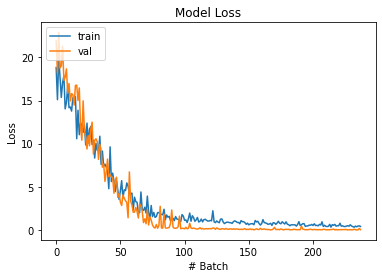

In [29]:
### Evaluation ###

import matplotlib.pyplot as plt

plt.plot(loss_history_train)
plt.plot(loss_history_val)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Batch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
### Evaluation ###

context = "Beijing (/ˌbeɪˈdʒɪŋ/ BAY-JING[10][11] Mandarin pronunciation: [pèi.tɕíŋ] (About this soundlisten)), alternatively romanized as Peking[12] (/ˌpiˈkɪŋ/ PEE-KING),[13] is the capital of the People's Republic of China. It is the world's most populous national capital city, with over 21 million residents within an administrative area of 16,410.5 km2 (6336 sq. mi.).[4] It is located in Northern China, is governed as a municipality under the direct administration of the State Council with 16 urban, suburban, and rural districts.[14] Beijing is mostly surrounded by Hebei Province with the exception of neighboring Tianjin to the southeast; together, the three divisions form the Jingjinji megalopolis and the national capital region of China"

question = "What is the capital of China?"

inputs = f"question: {question} context: {context}"

encoded_query = tokenizer(inputs, return_tensors='tf', pad_to_max_length=True, truncation=True, max_length=encoder_max_len)

input_ids = encoded_query["input_ids"]
attention_mask = encoded_query["attention_mask"]

generated_answer = model.generate(input_ids, attention_mask=attention_mask, 
                                 max_length=decoder_max_len, top_p=0.95, top_k=50, repetition_penalty=2)
decoded_answer = tokenizer.decode(generated_answer.numpy()[0])

print("Answer: ", decoded_answer)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Answer:  <pad> True</s>


#### Summarization

On CNN/Dailymail dataset; Also part of T5 tasks.

- Modelling - Eager: Ready
- Modelling - Static: WIP

In [ ]:
### Installs ###

!pip install -q datasets
!pip install -q transformers

In [5]:
### Imports ###

import transformers
import numpy as np
from datasets import load_dataset

# If import error below, restart session; reinstall transformers
from transformers import AutoTokenizer, TFT5ForConditionalGeneration

In [3]:
### Data ###

# 287,113 train samples; 13,368 val samples
train_ds = load_dataset("cnn_dailymail", "2.0.0", split='train')
valid_ds = load_dataset("cnn_dailymail", "2.0.0", split='validation')

# Subsample to 10K for faster training & quick testing
train_ds = train_ds.select(range(10000))
valid_ds = valid_ds.select(range(10000))

print("Example: ", next(iter(train_ds)))

# Tokenize data to prepare for feeding in model 
# Using huggingface tokenizer for now - We can easily swap this for a CN one lateron
tokenizer = AutoTokenizer.from_pretrained("t5-base")

# Max_lens from: https://github.com/google-research/text-to-text-transfer-transformer/blob/04776f4efae818030bce71c111d7042c11e8703b/t5/models/gin/sequence_lengths/cnn_dailymail_v002.gin
# Mean is 781 for article; 56 for highlights
encoder_max_len = 512
decoder_max_len = 128 # 512
batch_size = 2
buffer_size = 1000

ntrain = len(train_ds)
nvalid = len(valid_ds)
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))

def tokenize(example):
    """
    Prepares input example for model
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>"

    TODOs:
    - Remove max_len? 
    - In final stage adopt preprocessing from https://github.com/google-research/text-to-text-transfer-transformer/blob/867715664c8393cf12093ea9633f868c0df35548/t5/data/preprocessors.py
    """

    article = example["article"]
    summary = example["highlights"]

    inputs = f"summarize: {str(article)}"
    targets = f"{str(summary)}"

    # TODO: Do we need those two diff. input types?
    encoder_inputs = tokenizer(inputs, truncation=True, 
                              return_tensors='tf', padding="max_length", max_length=encoder_max_len)
    
    decoder_inputs = tokenizer(targets, truncation=True, 
                               return_tensors='tf', padding="max_length", max_length=decoder_max_len)
    
    outputs = {'input_ids': encoder_inputs['input_ids'][0], 'attention_mask': encoder_inputs['attention_mask'][0], 
               'labels': decoder_inputs['input_ids'][0], 'decoder_attention_mask': decoder_inputs['attention_mask'][0]}
    return outputs

def to_tf_dataset(dataset): 
  """
  Turns dataset into a TF compatible dataset via tf's from_generator
  """ 
  columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
  dataset.set_format(type='tensorflow', columns=columns)
  return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 
                'labels':tf.int32, 'decoder_attention_mask':tf.int32,  }
  return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]), 
                  'labels': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None])}
  ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
  return ds


train_ds = train_ds.map(tokenize)
valid_ds = valid_ds.map(tokenize)

train_ds = to_tf_dataset(train_ds)
valid_ds = to_tf_dataset(valid_ds)

train_ds = train_ds.shuffle(buffer_size).batch(batch_size)
valid_ds = valid_ds.shuffle(buffer_size).batch(batch_size)

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/0128610a44e10f25b4af6689441c72af86205282d26399642f7db38fa7535602)
Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/0128610a44e10f25b4af6689441c72af86205282d26399642f7db38fa7535602)


Example:  {'article': 'It\'s official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction." It\'s a step that is set to turn an international crisis into a fierce domestic political battle. There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react? In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to 

Loading cached processed dataset at /root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/0128610a44e10f25b4af6689441c72af86205282d26399642f7db38fa7535602/cache-4827f4f6826c3a1b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/0128610a44e10f25b4af6689441c72af86205282d26399642f7db38fa7535602/cache-87c4dd8c7238b381.arrow


In [6]:
### Modelling - Eager ###

learning_rate = 1e-5
model = TFT5ForConditionalGeneration.from_pretrained("t5-base")

loss_object = tf.keras.metrics.Mean(name='loss') 
optimizer = tf.keras.optimizers.Adam(learning_rate)

loss_history_train = []
loss_history_val = []

def train_step(data):
    x = data
    with tf.GradientTape() as tape:

        # > Feeds it just into TFT5ForConditionalGeneration; training=True turns on dropout
        outputs = model(x, training=True)
        # TODO: Manually compute loss; not have transformer autocompute it
        loss = outputs[0]
        # Reduce loss to single digit
        loss = tf.reduce_mean(loss)

    loss_history_train.append(loss.numpy().mean())
    # Calculate grads & update
    grads = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    

def test_step(data):
    x = data
    output = model(x, training=False)
    loss = output[0]
    loss = tf.reduce_mean(loss)
    loss_history_val.append(loss.numpy().mean())


def train(epochs, steps=-1):
  for epoch in range(epochs):
    for (batch, (train, val)) in enumerate(zip(train_ds, valid_ds)):
      train_step(train)
      test_step(val)
      if batch % 5 == 0:
        print('Batch {}, Last Train Loss {}, Last Val Loss {}'.format(batch, loss_history_train[-1], loss_history_val[-1]))

      if batch == steps:
        break 

    print ('Epoch {} finished'.format(epoch))


train(epochs=1, steps=500)

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Batch 0, Last Train Loss 9.202120780944824, Last Val Loss 9.99158000946045
Batch 5, Last Train Loss 8.323246002197266, Last Val Loss 8.111117362976074
Batch 10, Last Train Loss 7.096862316131592, Last Val Loss 9.064104080200195
Batch 15, Last Train Loss 5.784824848175049, Last Val Loss 8.216259002685547
Batch 20, Last Train Loss 4.890959739685059, Last Val Loss 5.232797145843506
Batch 25, Last Train Loss 3.9022815227508545, Last Val Loss 3.2586159706115723
Batch 30, Last Train Loss 3.077070474624634, Last Val Loss 3.4051480293273926
Batch 35, Last Train Loss 3.6157517433166504, Last Val Loss 3.261713981628418
Batch 40, Last Train Loss 3.3529109954833984, Last Val Loss 2.322368860244751
Batch 45, Last Train Loss 3.1860604286193848, Last Val Loss 3.5429272651672363
Batch 50, Last Train Loss 2.8773632049560547, Last Val Loss 2.822544813156128
Batch 55, Last Train Loss 2.354495048522949, Last Val Loss 1.2274950742721558
Batch 60, Last Train Loss 2.0779480934143066, Last Val Loss 2.22888278

KeyboardInterrupt: ignored

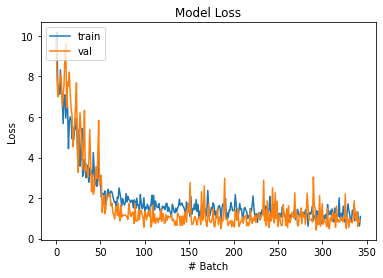

In [7]:
### Evaluation ###

import matplotlib.pyplot as plt

plt.plot(loss_history_train)
plt.plot(loss_history_val)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Batch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
### Evaluation ###

# Taken from https://en.wikipedia.org/wiki/Beijing
article = "Beijing (/ˌbeɪˈdʒɪŋ/ BAY-JING[10][11] Mandarin pronunciation: [pèi.tɕíŋ] (About this soundlisten)), alternatively romanized as Peking[12] (/ˌpiˈkɪŋ/ PEE-KING),[13] is the capital of the People's Republic of China. It is the world's most populous national capital city, with over 21 million residents within an administrative area of 16,410.5 km2 (6336 sq. mi.).[4] It is located in Northern China, is governed as a municipality under the direct administration of the State Council with 16 urban, suburban, and rural districts.[14] Beijing is mostly surrounded by Hebei Province with the exception of neighboring Tianjin to the southeast; together, the three divisions form the Jingjinji megalopolis and the national capital region of China.[15] \
Beijing is a global city, and one of the world's leading centers for culture, diplomacy and politics, business and economics, education, language, and science and technology. A megacity, Beijing is the second-largest Chinese city by urban population after Shanghai and is the nation's cultural, educational, and political center.[16] It is home to the headquarters of most of China's largest state-owned companies and houses the largest number of Fortune Global 500 companies in the world, as well as the world's four biggest financial institutions.[17][18] Beijing is the billionaire capital of the world with the highest number of billionaires living in the city.[19][20] It is also a major hub for the national highway, expressway, railway, and high-speed rail networks. The Beijing Capital International Airport has been the second busiest in the world by passenger traffic since 2010,[21] and, as of 2016, the city's subway network is the busiest and longest in the world. The Beijing Daxing International Airport, a second international airport in Beijing, is the largest single-structure airport terminal in the world.[22][23] \
Combining both modern and traditional style architectures, Beijing is one of the oldest cities in the world, with a rich history dating back three millennia. As the last of the Four Great Ancient Capitals of China, Beijing has been the political center of the country for most of the past eight centuries,[24] and was the largest city in the world by population for much of the second millennium AD.[25] With mountains surrounding the inland city on three sides, in addition to the old inner and outer city walls, Beijing was strategically poised and developed to be the residence of the emperor and thus was the perfect location for the imperial capital. The city is renowned for its opulent palaces, temples, parks, gardens, tombs, walls and gates.[26] It has seven UNESCO World Heritage Sites—the Forbidden City, Temple of Heaven, Summer Palace, Ming Tombs, Zhoukoudian, and parts of the Great Wall and the Grand Canal—all of which are popular tourist locations.[27] Siheyuans, the city's traditional housing style, and hutongs, the narrow alleys between siheyuans, are major tourist attractions and are common in urban Beijing. \
Many of Beijing's 91 universities[28] consistently rank among the best in the Asia Pacific and the world.[29][30] Beijing is home to the two best universities (Tsinghua and Peking) in the Asia Pacific and emerging countries.[31][32] Beijing CBD is a center for Beijing's economic expansion, with the ongoing or recently completed construction of multiple skyscrapers. Beijing's Zhongguancun area is a world leading center of scientific and technological innovation as well as entrepreneurship. Beijing has been ranked the No.1 city in the world for scientific research as tracked by the Nature Index since 2016.[33][34] The city has hosted numerous international and national sporting events, the most notable being the 2008 Summer Olympics and 2008 Summer Paralympics Games. Beijing will become the first city ever to host both the Summer and Winter Olympics,[35] and also the first city ever to host both the Summer and Winter Paralympics.[36] Beijing hosts 172 foreign embassies as well as the headquarters of the Asian Infrastructure Investment Bank (AIIB), the Shanghai Cooperation Organisation (SCO) and the Silk Road Fund. "

inputs = f"summarize: {str(article)}"

encoded_query = tokenizer(inputs, return_tensors='tf', pad_to_max_length=True, truncation=True, max_length=encoder_max_len)

input_ids = encoded_query["input_ids"]
attention_mask = encoded_query["attention_mask"]

generated_answer = model.generate(input_ids, attention_mask=attention_mask, 
                                 max_length=decoder_max_len, top_p=0.95, top_k=50, repetition_penalty=2)
decoded_answer = tokenizer.decode(generated_answer.numpy()[0])

print("Answer: ", decoded_answer)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Answer:  <pad> Beijing is the world's most populous national capital city. Beijing is home to many of china’ largest state-owned companies and financial institutions a megacity based in Beijing eqiuan jinping. Beijing has been the last of the Four Great Ancient Capital cities of China ; it is now the world' premier cultural center & cultural center...</s>


#### Translation

On WMT English-Chinese dataset from 2020; T5 used WMT datasets for English-French & English-Romanian translation <br>

Does not produce reasonable results on huggingface models as of now.

In [9]:
### Installs ###

# Needed for mT5
!pip install -q transformers[sentencepiece]

!pip install -q datasets
!pip install -q transformers

     |████████████████████████████████| 1.1MB 4.3MB/s 


In [10]:
### Imports ###

import transformers
import numpy as np
from datasets import load_dataset

# If import error below, restart session; reinstall transformers
from transformers import AutoTokenizer, TFXLMRobertaForMaskedLM

In [11]:
### Data ###

# Dict of form: dict_keys(['answers', 'context', 'id', 'question', 'title'])
train_ds = load_dataset("wmt20_mlqe_task2", "en-zh", split='train')
valid_ds = load_dataset("wmt20_mlqe_task2", "en-zh", split='validation')

print("Example: ", next(iter(train_ds))["translation"])

# Pretrained TFXLM - mT5 shows even worse results as no supervised pre-training
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

encoder_max_len = 20
decoder_max_len = 20
batch_size = 4
buffer_size = 1000

ntrain = len(train_ds)
nvalid = len(valid_ds)
steps = int(np.ceil(ntrain/batch_size))
valid_steps = int(np.ceil(nvalid/batch_size))

def tokenize(example, en_zh=False):
    """
    Prepares input example for model
    
    """
    en = example['translation']['en']
    zh = example['translation']['zh']

    if en_zh:
        inputs = f"translate: {str(en)}"
        targets = f"{str(zh)}"
    else:
        inputs = f"translate: {str(zh)}"
        targets = f"{str(en)}"

    # TODO: Do we need those two diff. input types?
    encoder_inputs = tokenizer(inputs, truncation=True, 
                              return_tensors='tf', padding="max_length", max_length=encoder_max_len)
    
    decoder_inputs = tokenizer(targets, truncation=True, 
                               return_tensors='tf', padding="max_length", max_length=decoder_max_len)
    
    outputs = {'input_ids': encoder_inputs['input_ids'][0], 'attention_mask': encoder_inputs['attention_mask'][0], 
               'labels': decoder_inputs['input_ids'][0], 'decoder_attention_mask': decoder_inputs['attention_mask'][0]}
    return outputs

def to_tf_dataset(dataset): 
  """
  Turns dataset into a TF compatible dataset; TODO: Combine with tokenize?  / Load TF dataset directly by loading Squad from tfds
  """ 
  columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
  dataset.set_format(type='tensorflow', columns=columns)
  return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 
                'labels':tf.int32, 'decoder_attention_mask':tf.int32,  }
  return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]), 
                  'labels': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None])}
  ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
  return ds


train_ds = train_ds.map(tokenize)
valid_ds = valid_ds.map(tokenize)

train_ds = to_tf_dataset(train_ds)
valid_ds = to_tf_dataset(valid_ds)

train_ds = train_ds.shuffle(buffer_size).batch(batch_size)
valid_ds = valid_ds.shuffle(buffer_size).batch(batch_size)



Reusing dataset wmt20_mlqe_task2 (/root/.cache/huggingface/datasets/wmt20_mlqe_task2/en-zh/1.1.0/9981db758dc33c011f45b9d30ad11c6bc427c341c72fd6dc9e5a994f6da3b046)
Reusing dataset wmt20_mlqe_task2 (/root/.cache/huggingface/datasets/wmt20_mlqe_task2/en-zh/1.1.0/9981db758dc33c011f45b9d30ad11c6bc427c341c72fd6dc9e5a994f6da3b046)


Example:  {'en': 'the last conquistador then rides on with his sword drawn .', 'zh': '最后 的 征服者 骑着 他 的 剑 继续前进 .'}


In [12]:
### Eager Modelling ###

model = TFXLMRobertaForMaskedLM.from_pretrained("jplu/tf-xlm-roberta-base")

learning_rate = 1e-5

loss_object = tf.keras.metrics.Mean(name='loss') 
optimizer = tf.keras.optimizers.Adam(learning_rate)

loss_history_train = []
loss_history_val = []

def train_step(data):
    x = data
    with tf.GradientTape() as tape:
        # > Feeds it just into TFT5ForConditionalGeneration; training=True turns on dropout
        outputs = model(x, training=True)
        # TODO: Manually compute loss; not have transformer autocompute it
        loss = outputs[0]  
        # Reduce loss to single digit
        loss = tf.reduce_mean(loss)

    loss_history_train.append(loss.numpy().mean())
    # Calculate grads & update
    grads = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
def test_step(data):
    x = data
    output = model(x, training=False)
    loss = output[0]
    loss = tf.reduce_mean(loss)
    loss_history_val.append(loss.numpy().mean())

def train(epochs, steps=-1):
  for epoch in range(epochs):
    for (batch, (train, val)) in enumerate(zip(train_ds, valid_ds)):
      train_step(train)
      test_step(val)
      if batch % 5 == 0:
        print('Batch {}, Last Train Loss {}, Last Val Loss {}'.format(batch, loss_history_train[-1], loss_history_val[-1]))

      if batch == steps:
        break 

    print ('Epoch {} finished'.format(epoch))

train(epochs=2, steps=500)

All model checkpoint layers were used when initializing TFXLMRobertaForMaskedLM.

All the layers of TFXLMRobertaForMaskedLM were initialized from the model checkpoint at jplu/tf-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForMaskedLM for predictions without further training.


Batch 0, Last Train Loss 24.055482864379883, Last Val Loss 20.661113739013672
Batch 5, Last Train Loss 9.834460258483887, Last Val Loss 9.746481895446777
Batch 10, Last Train Loss 7.3413987159729, Last Val Loss 7.716361999511719
Batch 15, Last Train Loss 8.128362655639648, Last Val Loss 7.010308265686035
Batch 20, Last Train Loss 8.930416107177734, Last Val Loss 7.637303352355957
Batch 25, Last Train Loss 7.020506381988525, Last Val Loss 7.0156683921813965
Batch 30, Last Train Loss 8.167766571044922, Last Val Loss 7.932093620300293
Batch 35, Last Train Loss 6.909090995788574, Last Val Loss 8.016721725463867
Batch 40, Last Train Loss 7.923210144042969, Last Val Loss 7.031032562255859
Batch 45, Last Train Loss 8.134921073913574, Last Val Loss 6.515093803405762
Batch 50, Last Train Loss 6.85300350189209, Last Val Loss 6.941930294036865
Batch 55, Last Train Loss 8.123805046081543, Last Val Loss 6.784092903137207
Batch 60, Last Train Loss 7.664870262145996, Last Val Loss 6.69750452041626
Ba

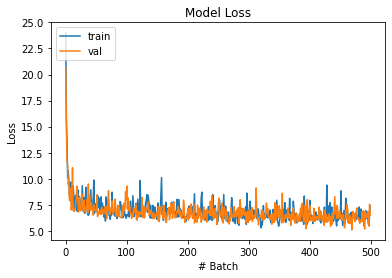

In [13]:
### Evaluation ###

import matplotlib.pyplot as plt

plt.plot(loss_history_train)
plt.plot(loss_history_val)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('# Batch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
### Evaluation ###

en = "the conquistador then rides on with his sword drawn."
zh = "最后 的 征服者 骑着 他 的 剑 继续前进 ."

inputs = f"translate: {str(zh)}"


encoded_query = tokenizer(inputs, return_tensors='tf', padding="max_length", truncation=True, max_length=encoder_max_len)

input_ids = encoded_query["input_ids"]
attention_mask = encoded_query["attention_mask"]

generated_answer = model.generate(input_ids, attention_mask=attention_mask,
                                 max_length=decoder_max_len+1, top_p=0.95, top_k=50, repetition_penalty=2)

decoded_answer = tokenizer.decode(generated_answer.numpy()[0])

print("Answer: ", decoded_answer)

Answer:  <s> translate: 最后 的 征服者 骑着 他 的 </s>,


#### Distributed Training Test

### TODOs

- Visualize Losses with TensorBoard